# Erstellen einer Datenbank

Auf einer SQL Instanz können maximal 32.767 Datenbanken angelegt werden.

## Erstellen einer Datenbank über das SSMS

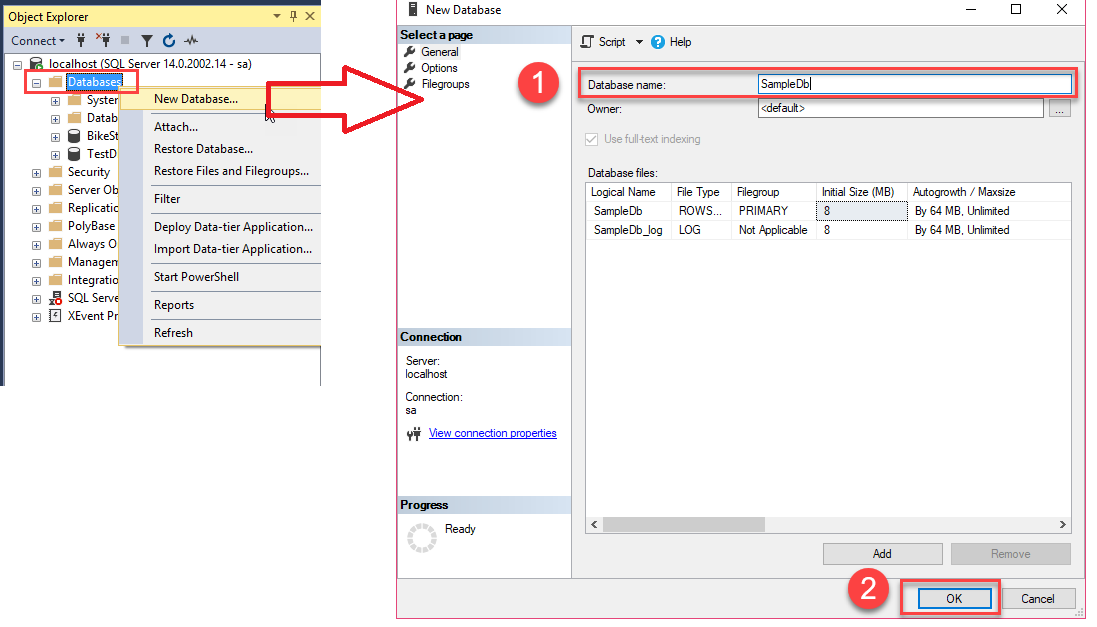  

## Erstellen einer Datenbank mittels T-SQL

In [ ]:
-- einfachster Weg:
CREATE DATABASE [BI_DatabaseBackup_Test]

In [ ]:
CREATE DATABASE [BI_DatabaseBackup_Test]
 CONTAINMENT = NONE
 ON  PRIMARY 
( NAME = N'BI_DatabaseBackup_Test', FILENAME = N'c:\Program Files\Microsoft SQL Server\MSSQL14.MSSQLSERVER\MSSQL\DATA\BI_DatabaseBackup_Test.mdf' , 
SIZE = 8192KB , MAXSIZE = UNLIMITED, FILEGROWTH = 65536KB )
 LOG ON 
( NAME = N'BI_DatabaseBackup_Test_log', FILENAME = N'c:\Program Files\Microsoft SQL Server\MSSQL14.MSSQLSERVER\MSSQL\DATA\BI_DatabaseBackup_Test_log.ldf' , 
SIZE = 8192KB , 
MAXSIZE = 2048GB , 
FILEGROWTH = 65536KB )
GO

## Containment

STANDARD: CONTAINMENT = NONE

Dh. Logins, temp. DB … werden nicht in der Master DB oder TempDB gespeichert, sondern in der jeweiligen DB.

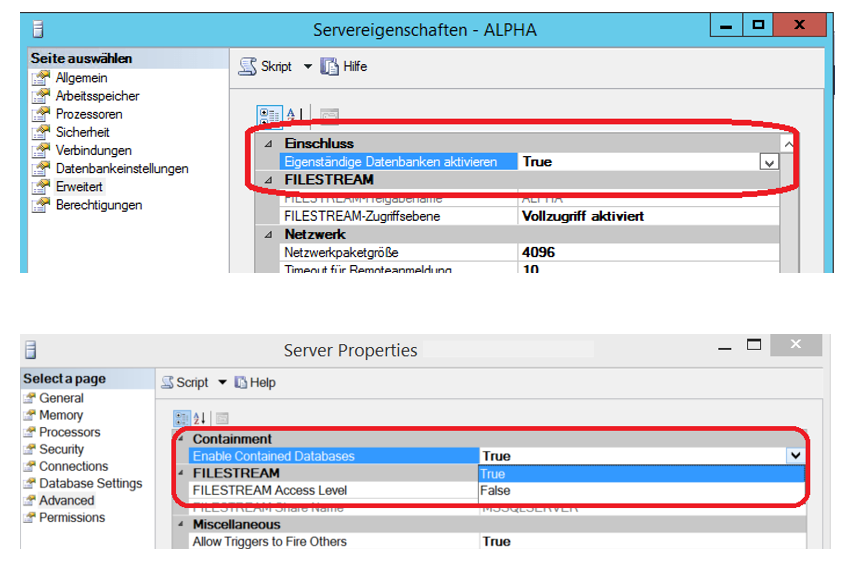  

<u>Vorteile einer “Contained Database”</u>

- DB inkl. User ist leichter zwischen Servern migrierbar

<u>Nachteile:</u>

- Datenbankübergreifende Zugriffe ohne weiteres nicht möglich (SET TRUSTWORTHY ON )
- keine Kerberos Authentifizierung möglich
- keine Replikation

In [ ]:
-- nachträgliches Ändern des Containments
ALTER DATABASE [BI_DatabaseBackup_Test] SET CONTAINMENT = PARTIAL WITH NO_WAIT
GO
/*
dh. es muss erlaubt werden, dass die Logins in der DB gespeichert werden darf.
sp_configure 'contained database authentication', 1;  
GO  
RECONFIGURE;  
GO  
*/

-- damit der datenbankübergreifende Zugriff trotz Containments funktioniert
ALTER DATABASE [BI_DatabaseBackup_Test] SET TRUSTWORTHY ON
GO

In [ ]:
-- in die neu erstellte DB wecheseln
USE [BI_DatabaseBackup_Test]
GO

## Collation

... definiert wie Daten in der DB sortiert und verglichen werden.

Abkürzungen:

- Case Sensitive vs Case Insensitive
    
    ```
      - CI = Case Inensitive [zB Latin1_General_CI_AI]
      - CS = Case Sensitive [zB Latin1_General_CS_AI]
    ```
    
- Accent Sensitive vs Accent Insensitive
    
    ```
      - AS = Accent Sensitive: a <> á 
      - AS = Accent Insensitive: a = á
    ```
    
- Japanses kana characters
    
    ```
      - KS = Kana Sensitive: Hiragana <> Katakana
    ```
    

zB: SQL\_Latin1\_Gerneral\_CP1\_CI\_AS

Latin1 = Charset Latin 1 ~ ASCII

CP1 = Code Page 1252

CI = Case In-Sensitive \[ToDo = TODO = todo\]

AS = Accent Sensitive

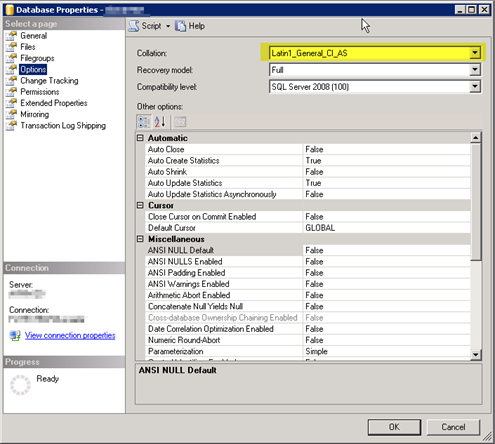

In [ ]:
-- Wenn man herausfinden möchte, was die ienzelnen Abkürzungen bedeuten:
Select name, description from sys.fn_helpcollations()

In [ ]:
select DATABASEPROPERTYEX('[BI_DatabaseBackup_Test]','collation')

In [ ]:
USE master;
GO
Select name, collation_name from sys.databases

## Collation Einstellungen des Servers

Standardmäßig leitet sich die Collation von den Einstellungen der SQL-Instanz ab. 

Standard: SQL\_Latin1\_General\_CP1\_CI\_AS

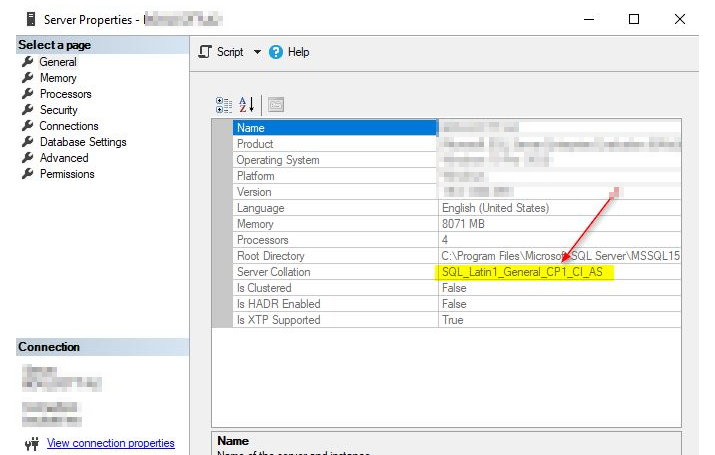

In [ ]:
select SERVERPROPERTY('collation')

## Volltextsuche

In [ ]:
USE [BI_DatabaseBackup_Test]
GO

-- prüfen, ob die Volltextsuche aktiviert ist [0 = nicht installiert | 1 = installiert]
Select fulltextserviceproperty('IsFulltextInstalled')

-- schöner:
SELECT 
CASE FULLTEXTSERVICEPROPERTY('IsFullTextInstalled')
    WHEN 1 THEN 'Full-Text installed.' 
    ELSE 'Full-Text is NOT installed.' 
END;

-- oder über DatabaseProperty
SELECT DATABASEPROPERTY (db_name(db_id()),'Is FulltextEnabled') -- für die aktuelle DB
SELECT DATABASEPROPERTY ('BI_DatabaseBackup_Test','Is FulltextEnabled') -- für eine andere DB

In [ ]:
USE [BI_DatabaseBackup_Test]
GO

IF (0 = FULLTEXTSERVICEPROPERTY('IsFullTextInstalled'))
begin
EXEC [BI_DatabaseBackup_Test].[dbo].[sp_fulltext_database] @action = 'enable'
end
GO

Wenn das nicht klappt, sollte man überprüfen, ob der "Full Text Daemon Launcher Service" rennt?

![enter image description here](https://i.stack.imgur.com/nEour.jpg)

Wenn dem nicht der Fall ist, muss dieses Feature installiert werden:

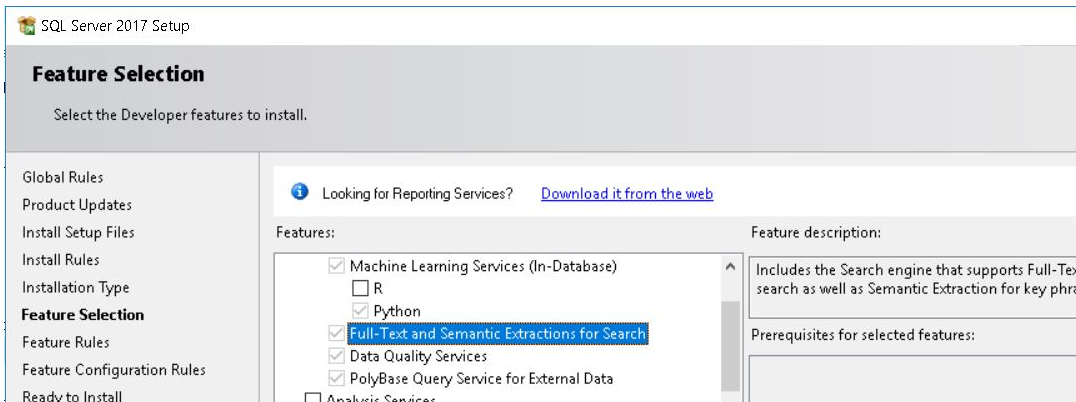

## SSMS & ANSI Settings

Wenn man über das SSMS Objekte erstellt, werden betsimmte ANSI Settings in der Connection zum Server gesetzt. (Tools \> Options \> Query Execution \> SQL server \> ANSI)

![SQL Server - ANSI_Padding and Scripting from SSMS](https://heelpbook.altervista.org/wp-content/uploads/2018/04/SSMS_ANSI_Options.jpg)  

Wenn diese nicht explizit im Eingabefenster geändert werden, greifen diese Einstellungen.

## ANSI\_NULL\_DEFAULT

Steuern des NULL Verhaltens in Spalten (Standard: 0)

- ANSI\_NULL\_DEFAULT OFF = 0 =\> eine neue Spalte, muss explizit als NULLABLE definiert sein, damit man NULL Values reinschreiben kann
- ANSI\_NULL\_DEFAULT ON = 1 =\> eine neue Spalte lässt NULL zu // entspricht SQL-92 Rules for Nullability

Details siehe Dokument <mark>\[ANSI\_NULL\_DEFAULT\]</mark>

In [ ]:
ALTER DATABASE [BI_DatabaseBackup_Test] SET ANSI_NULL_DEFAULT ON 
GO

In [ ]:
ALTER DATABASE [BI_DatabaseBackup_Test] SET ANSI_NULL_DEFAULT OFF 
GO

In [ ]:
SELECT DATABASEPROPERTYEX('BI_DatabaseBackup_Test','IsAnsiNullDefault');

In [ ]:
SELECT database_id , [name], is_ansi_null_default_on 
FROM sys.databases
-- Where [name] = 'BI_DatabaseBackup_Test'
ORDER BY name ASC;

## ANSI\_NULLS

spezifiziert das ISO compliant Verhalten von = und \<\> in Bezug auf NULL Values (Standard 1)

- ANSI\_NULL OFF = 0 =\> \<\> & = funktioniert nicht mit NULL
- ANSI\_NULL ON = 1 =\> \<\> & = funktioniert mit NULL

Details siehe Dokument \[**ANSI\_NULLS**\]

In [40]:
ALTER DATABASE [BI_DatabaseBackup_Test] SET ANSI_NULLS ON 
GO

Commands completed successfully.

Total execution time: 00:00:00.034

In [42]:
ALTER DATABASE [BI_DatabaseBackup_Test] SET ANSI_NULLS OFF 
GO

Commands completed successfully.

Total execution time: 00:00:00.015

In [43]:
SELECT DATABASEPROPERTYEX('BI_DatabaseBackup_Test','IsAnsiNullsEnabled');

(1 row affected)

Total execution time: 00:00:00.005

(No column name)
0


In [ ]:
SELECT database_id , [name], is_ansi_nulls_on 
FROM sys.databases
-- Where [name] = 'BI_DatabaseBackup_Test'
ORDER BY name ASC;

## ANSI\_PADDING

steuert das Verhalten von Werten, die kleiner sind als die Spalten (Default = 0)

- ANSI\_PADDING ON (1) = char und varchar verhalten sich unterschiedlich
    
- ANSI\_PADDING OFF (0) = char und varchar verhalten sich identisch

In [ ]:
ALTER DATABASE [BI_DatabaseBackup_Test] SET ANSI_PADDING ON 
GO

In [ ]:
ALTER DATABASE [BI_DatabaseBackup_Test] SET ANSI_PADDING OFF 
GO

In [47]:
SELECT DATABASEPROPERTYEX('BI_DatabaseBackup_Test','IsAnsiPaddingEnabled');

(1 row affected)

Total execution time: 00:00:00.003

(No column name)
0


In [ ]:
SELECT database_id , [name], is_ansi_padding_on 
FROM sys.databases
-- Where [name] = 'BI_DatabaseBackup_Test'
ORDER BY name ASC;

Über die sys.database kann man nur das Default Setting der Datenbank ermitteln. Einzelne Spalten können abweichende padding Settings haben \[siehe Dokument **ANSI\_PADDING**\]

## ANSI\_WARNINGS

... steuert das Verhalten in Bezug auf verschiedene Fehlermeldungen, wie 

- NULL Values bei Aggregationen
- Divisionen durch NULL
- STRING TRUNCATION

In [ ]:
ALTER DATABASE [BI_DatabaseBackup_Test] SET ANSI_WARNINGS ON 
GO

In [ ]:
ALTER DATABASE [BI_DatabaseBackup_Test] SET ANSI_WARNINGS OFF 
GO

In [51]:
SELECT DATABASEPROPERTYEX('BI_DatabaseBackup_Test','IsAnsiWarningsEnabled');

(1 row affected)

Total execution time: 00:00:00.004

(No column name)
0


In [ ]:
SELECT database_id , [name], is_ansi_warnings_on 
FROM sys.databases
-- Where [name] = 'BI_DatabaseBackup_Test'
ORDER BY name ASC;

# System-Datenbanken

Neben den User-Datenbanken, die wie oben beschrieben erstellt werden, gibt es noch eine Reihe von System-Datenbanken

- Master
- Model
- MSDB
- TempDB
- Resource (seit 2005)
- Distribution (nur bei aktivierter Replikation)